```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

# plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A06/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (eta_rho: 931, eta_u: 931, eta_v: 930, ocean_time: 24, s_rho: 35, s_w: 36, xi_rho: 981, xi_u: 980, xi_v: 981)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


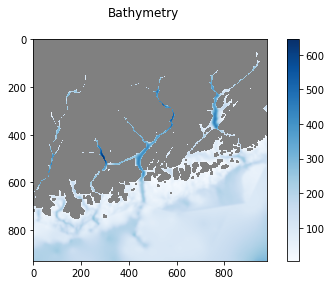

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

## Generating GPUOcean Simulation from Input

In [8]:
dimY, dimX = ds.h.data.shape

In [9]:
x0, x1, y0, y1 = 650, dimX-5, 5, dimY-525

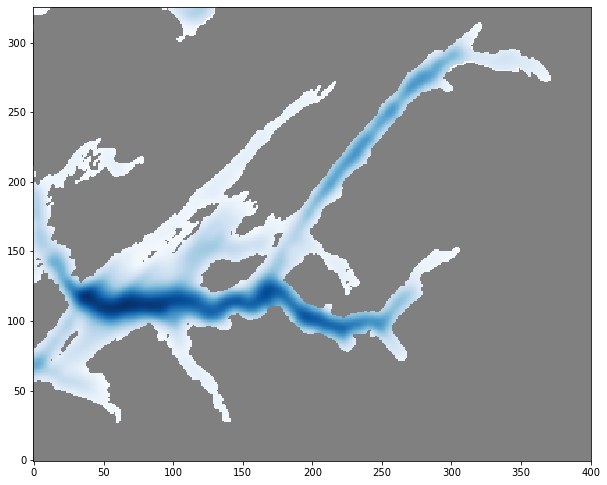

In [10]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

In [11]:
data_args = {}

In [12]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [13]:
data_args['nx'] = (x1-x0)-4
data_args['ny'] = (y1-y0)-4

NX = data_args["nx"]+4
NY = data_args["ny"]+4

data_args['dx'] = 160.0
data_args['dy'] = 160.0

In [14]:
data_args["dx"], data_args["dy"]

(160.0, 160.0)

In [15]:
data_args['angle'] = nc["angle"][y0:y1, x0:x1]
from gpuocean.utils import OceanographicUtilities
data_args['latitude'] = OceanographicUtilities.degToRad(nc.variables['lat_rho'][y0:y1, x0:x1])
data_args["f"] = 0.0

Check Mixed-Layer Depth

In [16]:
t=0

In [39]:
mld = NetCDFInitialization.MLD(source_url, 1025.5, min_mld=1.5, max_mld=100, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  


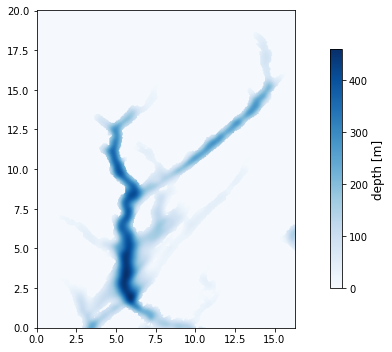

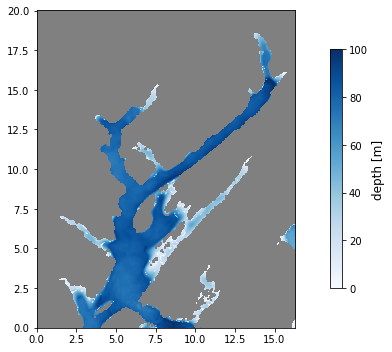

In [41]:
cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, mld.shape[1]*50/1000, 0, mld.shape[0]*50/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(nc["h"][y0:y1,x0:x1]==0)), 
                   vmin=0,
                   cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-bathymetry.pdf", dpi=200)


    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(mld, 
                    vmin=0, vmax=100,
                    cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-mld.pdf", dpi=200)


Check densities

In [32]:
y_cut = 115

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


2041-11-01 01:00:00


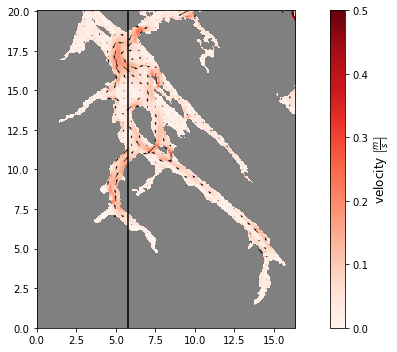

In [42]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)
hu = np.ma.array(np.sum(integrator * u, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])
hv = np.ma.array(np.sum(integrator * v, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])

u = hu/mld
v = hv/mld
velocity = np.sqrt(u*u + v*v)

ny, nx = velocity.shape
dx, dy = 0.050, 0.050
domain_extent = [0, nx*dx, 0, ny*dy]

frequency_x = 10
frequency_y = 10
x = np.arange(0, velocity.shape[1], frequency_x)*dx
y = np.arange(0, velocity.shape[0], frequency_y)*dy
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]


with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))

    # ax.tick_params(colors='black')
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Reds
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    ax.axvline(x=y_cut*dx, c="black")

    plt.tight_layout()

    # plt.savefig("figs/PotDensLine.pdf", dpi=200)

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


2041-11-01 01:00:00


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


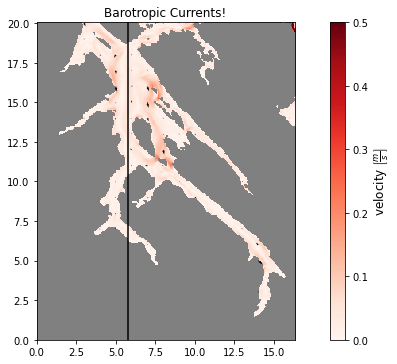

In [43]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

velocity = np.sqrt(u*u + v*v)

ny, nx = velocity.shape
dx, dy = 0.050, 0.050
domain_extent = [0, nx*dx, 0, ny*dy]

frequency_x = 20
frequency_y = 20
x = np.arange(0, velocity.shape[1], frequency_x)*dx
y = np.arange(0, velocity.shape[0], frequency_y)*dy
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]


with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))

    # ax.tick_params(colors='black')
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Reds
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    ax.axvline(x=y_cut*dx, c="black")

    plt.tight_layout()
    plt.title("Barotropic Currents!")

    # plt.savefig("figs/PotDensLine.pdf", dpi=200)

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))

In [36]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 150 # upper layer thickness for plotting in meters

depth_show_resolution = 1 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

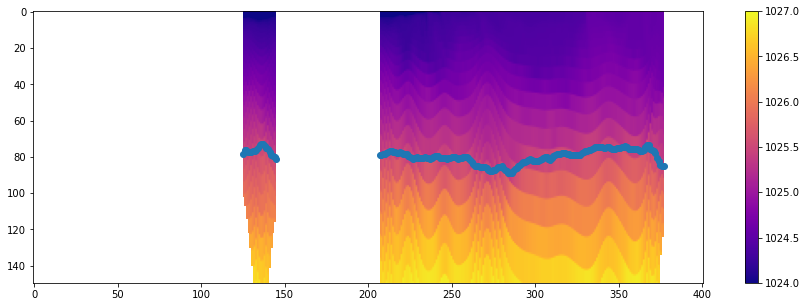

In [40]:
plt.figure(figsize=(15,5))
plt.imshow(s_pot_densities_show.T, origin="upper", cmap="plasma",  aspect='auto', vmin=1024, vmax=1027)
plt.colorbar()
plt.scatter(np.arange(s_pot_densities.shape[1]), mld[:,y_cut])